# Total Runtime: ~35 minutes

In [1]:
# Load essential libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv("data/statcast_2023.csv")

# Basic sanity checks
print(" Data loaded successfully!")
print(f"Number of rows: {len(df)}")
print(f"Number of columns: {len(df.columns)}")

# Show the first few rows
print("\n Preview of the dataset:")
print(df.head())

# List all column names
print("\n Column names:")
print(df.columns.tolist())

# Check for missing values in all columns
print("\n Missing values per column:")
print(df.isna().sum().sort_values(ascending=False))


 Data loaded successfully!
Number of rows: 720684
Number of columns: 118

 Preview of the dataset:
  pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
0         CH  2023-10-01           89.0          -2.80           5.59   
1         FF  2023-10-01           96.9          -2.40           5.90   
2         CH  2023-10-01           90.0          -2.93           5.56   
3         ST  2023-10-01           82.2          -3.09           5.55   
4         CH  2023-10-01           89.2          -2.87           5.58   

       player_name  batter  pitcher     events      description  ...  \
0  Robertson, Nick  677008   687798  field_out    hit_into_play  ...   
1  Robertson, Nick  677008   687798        NaN             foul  ...   
2  Robertson, Nick  677008   687798        NaN             ball  ...   
3  Robertson, Nick  677008   687798        NaN             ball  ...   
4  Robertson, Nick  677008   687798        NaN  swinging_strike  ...   

   batter_days_until_next_gam

In [2]:
# Initialize engineered dataset

# Start with a copy of the original dataframe
engineered_data = df.copy()

# Define target variable
target = "pitch_type"

# Initialize feature lists 
numeric_features = [
    "release_speed", "release_pos_x", "release_pos_z",
    "plate_x", "plate_z", "release_spin_rate", "pfx_x", "pfx_z"
]

categorical_features = [
    "stand",        # batter handedness
    "p_throws",     # pitcher handedness
    "count",        # balls-strikes count
    "inning",       # inning number
    "outs_when_up"  # number of outs
]

# Print initial setup
print("\nTarget variable:", target)
print("\nNumeric features:", numeric_features)
print("\nCategorical features:", categorical_features)
print("\nShape of engineered_data:", engineered_data.shape)
print(engineered_data.head())



Target variable: pitch_type

Numeric features: ['release_speed', 'release_pos_x', 'release_pos_z', 'plate_x', 'plate_z', 'release_spin_rate', 'pfx_x', 'pfx_z']

Categorical features: ['stand', 'p_throws', 'count', 'inning', 'outs_when_up']

Shape of engineered_data: (720684, 118)
  pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
0         CH  2023-10-01           89.0          -2.80           5.59   
1         FF  2023-10-01           96.9          -2.40           5.90   
2         CH  2023-10-01           90.0          -2.93           5.56   
3         ST  2023-10-01           82.2          -3.09           5.55   
4         CH  2023-10-01           89.2          -2.87           5.58   

       player_name  batter  pitcher     events      description  ...  \
0  Robertson, Nick  677008   687798  field_out    hit_into_play  ...   
1  Robertson, Nick  677008   687798        NaN             foul  ...   
2  Robertson, Nick  677008   687798        NaN             ball

In [3]:
# Feature Engineering Block

# Previous pitch type (sequencing)
engineered_data['prev_pitch_type'] = engineered_data['pitch_type'].shift(1)
engineered_data['same_pitcher_game'] = (
    (engineered_data['pitcher'] == engineered_data['pitcher'].shift(1)) &
    (engineered_data['game_pk'] == engineered_data['game_pk'].shift(1))
)
engineered_data.loc[~engineered_data['same_pitcher_game'], 'prev_pitch_type'] = np.nan

# Score differential
engineered_data['score_diff'] = engineered_data['home_score'] - engineered_data['away_score']

# Runner presence (binary feature)
engineered_data['runner_on'] = (
    engineered_data['on_1b'].notna() |
    engineered_data['on_2b'].notna() |
    engineered_data['on_3b'].notna()
).astype(int)

# Count pressure (balls - strikes difference)
engineered_data['count_pressure'] = engineered_data['balls'] - engineered_data['strikes']

# Is two-strike situation (binary)
engineered_data['two_strikes'] = (engineered_data['strikes'] >= 2).astype(int)

# Create count feature (balls-strikes string)
engineered_data['count'] = engineered_data['balls'].astype(str) + "-" + engineered_data['strikes'].astype(str)

# Safely update feature lists (no duplicates)
for f in ['prev_pitch_type', 'runner_on', 'two_strikes']:
    if f not in categorical_features:
        categorical_features.append(f)

for f in ['score_diff', 'count_pressure']:
    if f not in numeric_features:
        numeric_features.append(f)

# Print confirmation
print("\nEngineered features added safely.")
print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)
print("\nShape of engineered_data:", engineered_data.shape)
print(engineered_data[['pitch_type','prev_pitch_type','score_diff','runner_on','count_pressure','two_strikes']].head(10))



Engineered features added safely.
Categorical features: ['stand', 'p_throws', 'count', 'inning', 'outs_when_up', 'prev_pitch_type', 'runner_on', 'two_strikes']
Numeric features: ['release_speed', 'release_pos_x', 'release_pos_z', 'plate_x', 'plate_z', 'release_spin_rate', 'pfx_x', 'pfx_z', 'score_diff', 'count_pressure']

Shape of engineered_data: (720684, 125)
  pitch_type prev_pitch_type  score_diff  runner_on  count_pressure  \
0         CH             NaN          -5          0               0   
1         FF              CH          -5          0               0   
2         CH              FF          -5          0              -1   
3         ST              CH          -5          0              -2   
4         CH              ST          -5          0              -1   
5         FF              CH          -5          0               0   
6         CH              FF          -5          0               0   
7         FF              CH          -5          0               0

In [4]:
# Encode categorical variables

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

print("Preprocessor pipeline created successfully.")
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Preprocessor pipeline created successfully.
Numeric features: ['release_speed', 'release_pos_x', 'release_pos_z', 'plate_x', 'plate_z', 'release_spin_rate', 'pfx_x', 'pfx_z', 'score_diff', 'count_pressure']
Categorical features: ['stand', 'p_throws', 'count', 'inning', 'outs_when_up', 'prev_pitch_type', 'runner_on', 'two_strikes']


In [5]:
#  Train/Test Split

engineered_data.columns = engineered_data.columns.str.strip()

# Drop rows with missing target or engineered features
model_df = engineered_data[[target] + numeric_features + categorical_features].dropna()

# Define X (features) and y (target)
X = model_df[numeric_features + categorical_features]
y = model_df[target]

# Train/test split (stratify to preserve pitch type distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train/Test split complete.")
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Target distribution in training set:\n", y_train.value_counts(normalize=True).round(3))
print("Target distribution in test set:\n", y_test.value_counts(normalize=True).round(3))


Train/Test split complete.
Training set size: (531731, 18)
Test set size: (132933, 18)
Target distribution in training set:
 pitch_type
FF    0.324
SL    0.160
SI    0.154
CH    0.108
FC    0.079
CU    0.066
ST    0.058
FS    0.022
KC    0.021
SV    0.004
FA    0.002
FO    0.001
EP    0.001
KN    0.000
SC    0.000
CS    0.000
PO    0.000
Name: proportion, dtype: float64
Target distribution in test set:
 pitch_type
FF    0.324
SL    0.160
SI    0.154
CH    0.108
FC    0.079
CU    0.066
ST    0.058
FS    0.022
KC    0.021
SV    0.004
FA    0.002
FO    0.001
EP    0.001
KN    0.000
SC    0.000
CS    0.000
PO    0.000
Name: proportion, dtype: float64


In [6]:
# Baseline Model Pipeline with Accuracy & F1

# Deduplicate feature lists just in case
numeric_features = list(dict.fromkeys(numeric_features))
categorical_features = list(dict.fromkeys(categorical_features))

# Build pipeline: preprocessing + classifier
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=500,
        multi_class="multinomial",
        solver="saga",
        class_weight="balanced"
    ))
])

# Fit model
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")

print("Baseline Logistic Regression model trained.")
print(f"Test set accuracy: {acc:.3f}")
print(f"Macro F1 score: {f1_macro:.3f}")

# Optional: detailed per-class report
print("\nClassification Report (per class):")
print(classification_report(y_test, y_pred, digits=3))


C:\Users\justi\miniconda3\envs\cs506\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\justi\miniconda3\envs\cs506\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Baseline Logistic Regression model trained.
Test set accuracy: 0.650
Macro F1 score: 0.491

Classification Report (per class):
              precision    recall  f1-score   support

          CH      0.386     0.667     0.489     14369
          CS      0.036     0.923     0.069        13
          CU      0.838     0.560     0.671      8822
          EP      0.605     0.922     0.731       103
          FA      0.509     0.826     0.630       207
          FC      0.497     0.555     0.525     10554
          FF      0.931     0.765     0.840     43013
          FO      0.657     0.479     0.554       140
          FS      0.418     0.776     0.544      2933
          KC      0.413     0.638     0.502      2752
          KN      0.525     0.865     0.653        37
          PO      0.003     0.667     0.005         9
          SC      0.022     0.462     0.043        13
          SI      0.747     0.624     0.680     20474
          SL      0.784     0.505     0.614     21268
        

In [7]:
# Encode target labels for XGBoost

label_encoder = LabelEncoder()

# Fit on training labels and transform both train/test
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

print("Classes:", label_encoder.classes_)
print("First 10 encoded labels (train):", y_train_enc[:10])


Classes: ['CH' 'CS' 'CU' 'EP' 'FA' 'FC' 'FF' 'FO' 'FS' 'KC' 'KN' 'PO' 'SC' 'SI'
 'SL' 'ST' 'SV']
First 10 encoded labels (train): [ 2 13  5 14 14  6 13  6  6 13]


In [8]:
# XGBoost Model Pipeline

xgb_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        eval_metric="mlogloss",
        random_state=42
    ))
])

# Fit model on encoded labels
xgb_clf.fit(X_train, y_train_enc)

# Predictions (numeric)
y_pred_xgb = xgb_clf.predict(X_test)

# Decode predictions back to original pitch labels
y_pred_labels = label_encoder.inverse_transform(y_pred_xgb)

# Metrics
acc_xgb = accuracy_score(y_test, y_pred_labels)
f1_macro_xgb = f1_score(y_test, y_pred_labels, average="macro")

print("XGBoost model trained.")
print(f"Test set accuracy: {acc_xgb:.3f}")
print(f"Macro F1 score: {f1_macro_xgb:.3f}")
print("\nClassification Report (per class):")
print(classification_report(y_test, y_pred_labels, digits=3))


XGBoost model trained.
Test set accuracy: 0.930
Macro F1 score: 0.841

Classification Report (per class):
              precision    recall  f1-score   support

          CH      0.945     0.964     0.954     14369
          CS      0.833     0.385     0.526        13
          CU      0.917     0.911     0.914      8822
          EP      0.896     0.922     0.909       103
          FA      0.932     0.923     0.927       207
          FC      0.874     0.832     0.852     10554
          FF      0.968     0.974     0.971     43013
          FO      0.937     0.843     0.887       140
          FS      0.920     0.836     0.876      2933
          KC      0.927     0.826     0.874      2752
          KN      1.000     0.865     0.928        37
          PO      0.500     0.111     0.182         9
          SC      1.000     0.846     0.917        13
          SI      0.945     0.938     0.942     20474
          SL      0.878     0.912     0.895     21268
          ST      0.883     0

In [9]:
# Neural Network Model Pipeline

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Build preprocessing + NN pipeline
# First transform features using preprocessor
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# Define neural network architecture
nn_model = keras.Sequential([
    layers.Input(shape=(X_train_proc.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(label_encoder.classes_), activation="softmax")
])

# Compile model
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train model
history = nn_model.fit(
    X_train_proc, y_train_enc,
    validation_split=0.1,
    epochs=15,
    batch_size=1024,
    verbose=2
)

# Evaluate
y_pred_nn = nn_model.predict(X_test_proc)
y_pred_labels = label_encoder.inverse_transform(y_pred_nn.argmax(axis=1))

acc_nn = accuracy_score(y_test, y_pred_labels)
f1_macro_nn = f1_score(y_test, y_pred_labels, average="macro")

print("Neural Network model trained.")
print(f"Test set accuracy: {acc_nn:.3f}")
print(f"Macro F1 score: {f1_macro_nn:.3f}")
print("\nClassification Report (per class):")
print(classification_report(y_test, y_pred_labels, digits=3))


Epoch 1/15
468/468 - 2s - 5ms/step - accuracy: 0.7722 - loss: 0.6559 - val_accuracy: 0.8574 - val_loss: 0.3890
Epoch 2/15
468/468 - 2s - 4ms/step - accuracy: 0.8477 - loss: 0.4205 - val_accuracy: 0.8663 - val_loss: 0.3614
Epoch 3/15
468/468 - 2s - 4ms/step - accuracy: 0.8572 - loss: 0.3919 - val_accuracy: 0.8711 - val_loss: 0.3467
Epoch 4/15
468/468 - 2s - 4ms/step - accuracy: 0.8631 - loss: 0.3765 - val_accuracy: 0.8746 - val_loss: 0.3348
Epoch 5/15
468/468 - 2s - 4ms/step - accuracy: 0.8670 - loss: 0.3646 - val_accuracy: 0.8789 - val_loss: 0.3261
Epoch 6/15
468/468 - 2s - 4ms/step - accuracy: 0.8697 - loss: 0.3558 - val_accuracy: 0.8822 - val_loss: 0.3174
Epoch 7/15
468/468 - 2s - 4ms/step - accuracy: 0.8722 - loss: 0.3495 - val_accuracy: 0.8840 - val_loss: 0.3122
Epoch 8/15
468/468 - 2s - 4ms/step - accuracy: 0.8739 - loss: 0.3432 - val_accuracy: 0.8850 - val_loss: 0.3071
Epoch 9/15
468/468 - 2s - 4ms/step - accuracy: 0.8762 - loss: 0.3392 - val_accuracy: 0.8873 - val_loss: 0.3033
E

C:\Users\justi\miniconda3\envs\cs506\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\justi\miniconda3\envs\cs506\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

          CH      0.915     0.945     0.929     14369
          CS      0.667     0.308     0.421        13
          CU      0.844     0.860     0.852      8822
          EP      0.811     0.961     0.880       103
          FA      0.922     0.855     0.887       207
          FC      0.834     0.752     0.791     10554
          FF      0.955     0.967     0.961     43013
          FO      0.887     0.614     0.726       140
          FS      0.864     0.757     0.807      2933
          KC      0.864     0.639     0.734      2752
          KN      0.938     0.811     0.870        37
          PO      0.000     0.000     0.000         9
          SC      0.667     0.308     0.421        13
          SI      0.927     0.914     0.921     20474
          SL      0.823     0.885     0.853     21268
          ST      0.838     0.817     0.827      7698
          SV      0.880     0.638     0.740       528

    accuracy              

C:\Users\justi\miniconda3\envs\cs506\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Note: I ran this code below for hyperparameter tuning but it takes 6.5 hours to run so it is set to Markdown. The results are shown in the final report.

# XGBoost Hyperparameter Tuning

xgb_base = XGBClassifier(
    objective="multi:softmax",
    eval_metric="mlogloss",
    random_state=42,
    use_label_encoder=False
)

from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    "n_estimators": np.linspace(300, 1000, 10, dtype=int),
    "learning_rate": [0.1, 0.05, 0.01],
    "max_depth": [6, 8, 10],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 1, 5],
    "reg_lambda": [1, 5, 10],
    "reg_alpha": [0, 1, 5]
}

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=75,              # sample 75 random combos
    scoring="f1_macro",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_proc, y_train_enc)
print("Best params:", random_search.best_params_)
print("Best macro F1:", random_search.best_score_)


In [10]:
# Side-by-side comparison: Baseline vs Weighted vs Grouped

# --- 1. Baseline tuned model ---
xgb_baseline = XGBClassifier(
    n_estimators=844, learning_rate=0.1, max_depth=8,
    subsample=0.9, colsample_bytree=0.7,
    min_child_weight=1, gamma=0,
    reg_lambda=10, reg_alpha=1,
    objective="multi:softmax", eval_metric="mlogloss",
    random_state=42
)
xgb_baseline.fit(X_train_proc, y_train_enc)
y_pred_base = xgb_baseline.predict(X_test_proc)
y_pred_base_labels = label_encoder.inverse_transform(y_pred_base)

print("\n--- Baseline Tuned Model ---")
print("Accuracy:", accuracy_score(y_test, y_pred_base_labels))
print("Macro F1:", f1_score(y_test, y_pred_base_labels, average="macro"))

# --- 2. Weighted model ---
classes = np.unique(y_train_enc)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_enc)
class_weights = dict(zip(classes, weights))

xgb_weighted = XGBClassifier(
    n_estimators=844, learning_rate=0.1, max_depth=8,
    subsample=0.9, colsample_bytree=0.7,
    min_child_weight=1, gamma=0,
    reg_lambda=10, reg_alpha=1,
    objective="multi:softmax", eval_metric="mlogloss",
    random_state=42
)
xgb_weighted.fit(X_train_proc, y_train_enc,
                 sample_weight=[class_weights[label] for label in y_train_enc])
y_pred_weighted = xgb_weighted.predict(X_test_proc)
y_pred_weighted_labels = label_encoder.inverse_transform(y_pred_weighted)

print("\n--- Weighted Model ---")
print("Accuracy:", accuracy_score(y_test, y_pred_weighted_labels))
print("Macro F1:", f1_score(y_test, y_pred_weighted_labels, average="macro"))

# --- 3. Grouped model ---
rare_classes = ["PO", "CS", "SC"]
y_train_grouped = y_train.replace(rare_classes, "OTHER")
y_test_grouped = y_test.replace(rare_classes, "OTHER")

# Encode grouped labels
label_encoder_grouped = LabelEncoder()
y_train_grouped_enc = label_encoder_grouped.fit_transform(y_train_grouped)
y_test_grouped_enc = label_encoder_grouped.transform(y_test_grouped)

xgb_grouped = XGBClassifier(
    n_estimators=844, learning_rate=0.1, max_depth=8,
    subsample=0.9, colsample_bytree=0.7,
    min_child_weight=1, gamma=0,
    reg_lambda=10, reg_alpha=1,
    objective="multi:softmax", eval_metric="mlogloss",
    random_state=42
)
xgb_grouped.fit(X_train_proc, y_train_grouped_enc)
y_pred_grouped = xgb_grouped.predict(X_test_proc)
y_pred_grouped_labels = label_encoder_grouped.inverse_transform(y_pred_grouped)

print("\n--- Grouped Model ---")
print("Accuracy:", accuracy_score(y_test_grouped, y_pred_grouped_labels))
print("Macro F1:", f1_score(y_test_grouped, y_pred_grouped_labels, average="macro"))



--- Baseline Tuned Model ---
Accuracy: 0.9372691506247508
Macro F1: 0.8397405857041023

--- Weighted Model ---
Accuracy: 0.932943663349206
Macro F1: 0.8730904546014301

--- Grouped Model ---
Accuracy: 0.937186402172523
Macro F1: 0.8884731310101784


In [11]:
# Further Feature Engineering Block

# Pitch sequencing: last 3 pitch types
for lag in [1, 2, 3]:
    engineered_data[f'pitch_type_lag{lag}'] = engineered_data['pitch_type'].shift(lag)
    if f'pitch_type_lag{lag}' not in categorical_features:
        categorical_features.append(f'pitch_type_lag{lag}')

# Pitcher fatigue: pitch count within game
engineered_data['pitch_count_game'] = engineered_data.groupby(['game_pk','pitcher']).cumcount() + 1
if 'pitch_count_game' not in numeric_features:
    numeric_features.append('pitch_count_game')

# Batter fatigue: plate appearance count within game
engineered_data['pa_count_game'] = engineered_data.groupby(['game_pk','batter']).cumcount() + 1
if 'pa_count_game' not in numeric_features:
    numeric_features.append('pa_count_game')

# Inning context
engineered_data['early_inning'] = (engineered_data['inning'] <= 3).astype(int)
engineered_data['mid_inning'] = ((engineered_data['inning'] >= 4) & (engineered_data['inning'] <= 6)).astype(int)
engineered_data['late_inning'] = (engineered_data['inning'] >= 7).astype(int)
for f in ['early_inning','mid_inning','late_inning']:
    if f not in categorical_features:
        categorical_features.append(f)

# Leverage proxy
engineered_data['leverage_proxy'] = engineered_data['score_diff'] / (engineered_data['inning'] + 1)
if 'leverage_proxy' not in numeric_features:
    numeric_features.append('leverage_proxy')

# Handedness matchup (robust: check column names)
if 'batter_hand' in engineered_data.columns and 'pitcher_hand' in engineered_data.columns:
    engineered_data['hand_matchup'] = engineered_data['batter_hand'] + "_" + engineered_data['pitcher_hand']
elif 'stand' in engineered_data.columns and 'p_throws' in engineered_data.columns:
    engineered_data['hand_matchup'] = engineered_data['stand'] + "_" + engineered_data['p_throws']
else:
    engineered_data['hand_matchup'] = "unknown"
if 'hand_matchup' not in categorical_features:
    categorical_features.append('hand_matchup')

# Runner situation detail
engineered_data['runners_on_base'] = (
    engineered_data[['on_1b','on_2b','on_3b']].notna().sum(axis=1)
)
if 'runners_on_base' not in numeric_features:
    numeric_features.append('runners_on_base')

# Rolling averages (last 10 pitches per pitcher)
if 'release_speed' in engineered_data.columns:
    engineered_data['rolling_velo'] = engineered_data.groupby('pitcher')['release_speed'].transform(lambda x: x.rolling(10, min_periods=1).mean())
    if 'rolling_velo' not in numeric_features:
        numeric_features.append('rolling_velo')
if 'release_spin_rate' in engineered_data.columns:
    engineered_data['rolling_spin'] = engineered_data.groupby('pitcher')['release_spin_rate'].transform(lambda x: x.rolling(10, min_periods=1).mean())
    if 'rolling_spin' not in numeric_features:
        numeric_features.append('rolling_spin')

# Situational flags
engineered_data['full_count'] = ((engineered_data['balls'] == 3) & (engineered_data['strikes'] == 2)).astype(int)
engineered_data['strikeout_pitch'] = (engineered_data['strikes'] == 2).astype(int)
for f in ['full_count','strikeout_pitch']:
    if f not in categorical_features:
        categorical_features.append(f)

# Batter familiarity
engineered_data['batter_seen_pitcher'] = engineered_data.groupby(['game_pk','pitcher','batter']).cumcount().gt(0).astype(int)
if 'batter_seen_pitcher' not in categorical_features:
    categorical_features.append('batter_seen_pitcher')

# Pitcher home/away
if 'pitcher_team' in engineered_data.columns and 'home_team' in engineered_data.columns:
    engineered_data['is_home_pitcher'] = (engineered_data['pitcher_team'] == engineered_data['home_team']).astype(int)
    if 'is_home_pitcher' not in categorical_features:
        categorical_features.append('is_home_pitcher')

# Print confirmation
print("\nExtreme engineered features added safely.")
print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)
print("\nShape of engineered_data:", engineered_data.shape)
print(engineered_data.head(15))



Extreme engineered features added safely.
Categorical features: ['stand', 'p_throws', 'count', 'inning', 'outs_when_up', 'prev_pitch_type', 'runner_on', 'two_strikes', 'pitch_type_lag1', 'pitch_type_lag2', 'pitch_type_lag3', 'early_inning', 'mid_inning', 'late_inning', 'hand_matchup', 'full_count', 'strikeout_pitch', 'batter_seen_pitcher']
Numeric features: ['release_speed', 'release_pos_x', 'release_pos_z', 'plate_x', 'plate_z', 'release_spin_rate', 'pfx_x', 'pfx_z', 'score_diff', 'count_pressure', 'pitch_count_game', 'pa_count_game', 'leverage_proxy', 'runners_on_base', 'rolling_velo', 'rolling_spin']

Shape of engineered_data: (720684, 141)
   pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
0          CH  2023-10-01           89.0          -2.80           5.59   
1          FF  2023-10-01           96.9          -2.40           5.90   
2          CH  2023-10-01           90.0          -2.93           5.56   
3          ST  2023-10-01           82.2          -

In [12]:
# Side-by-side comparison: Baseline vs Weighted vs Grouped (with extra features)

# Re-transform train/test with updated feature lists
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# --- 1. Baseline tuned model ---
xgb_baseline = XGBClassifier(
    n_estimators=844, learning_rate=0.1, max_depth=8,
    subsample=0.9, colsample_bytree=0.7,
    min_child_weight=1, gamma=0,
    reg_lambda=10, reg_alpha=1,
    objective="multi:softmax", eval_metric="mlogloss",
    random_state=42
)
xgb_baseline.fit(X_train_proc, y_train_enc)
y_pred_base = xgb_baseline.predict(X_test_proc)
y_pred_base_labels = label_encoder.inverse_transform(y_pred_base)

print("\n--- Baseline Tuned Model (Extra Features) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_base_labels))
print("Macro F1:", f1_score(y_test, y_pred_base_labels, average="macro"))

# --- 2. Weighted model ---
classes = np.unique(y_train_enc)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_enc)
class_weights = dict(zip(classes, weights))

xgb_weighted = XGBClassifier(
    n_estimators=844, learning_rate=0.1, max_depth=8,
    subsample=0.9, colsample_bytree=0.7,
    min_child_weight=1, gamma=0,
    reg_lambda=10, reg_alpha=1,
    objective="multi:softmax", eval_metric="mlogloss",
    random_state=42
)
xgb_weighted.fit(X_train_proc, y_train_enc,
                 sample_weight=[class_weights[label] for label in y_train_enc])
y_pred_weighted = xgb_weighted.predict(X_test_proc)
y_pred_weighted_labels = label_encoder.inverse_transform(y_pred_weighted)

print("\n--- Weighted Model (Extra Features) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_weighted_labels))
print("Macro F1:", f1_score(y_test, y_pred_weighted_labels, average="macro"))

# --- 3. Grouped model ---
rare_classes = ["PO", "CS", "SC"]
y_train_grouped = y_train.replace(rare_classes, "OTHER")
y_test_grouped = y_test.replace(rare_classes, "OTHER")

# Encode grouped labels
label_encoder_grouped = LabelEncoder()
y_train_grouped_enc = label_encoder_grouped.fit_transform(y_train_grouped)
y_test_grouped_enc = label_encoder_grouped.transform(y_test_grouped)

xgb_grouped = XGBClassifier(
    n_estimators=844, learning_rate=0.1, max_depth=8,
    subsample=0.9, colsample_bytree=0.7,
    min_child_weight=1, gamma=0,
    reg_lambda=10, reg_alpha=1,
    objective="multi:softmax", eval_metric="mlogloss",
    random_state=42
)
xgb_grouped.fit(X_train_proc, y_train_grouped_enc)
y_pred_grouped = xgb_grouped.predict(X_test_proc)
y_pred_grouped_labels = label_encoder_grouped.inverse_transform(y_pred_grouped)

print("\n--- Grouped Model (Extra Features) ---")
print("Accuracy:", accuracy_score(y_test_grouped, y_pred_grouped_labels))
print("Macro F1:", f1_score(y_test_grouped, y_pred_grouped_labels, average="macro"))



--- Baseline Tuned Model (Extra Features) ---
Accuracy: 0.9372691506247508
Macro F1: 0.8397405857041023

--- Weighted Model (Extra Features) ---
Accuracy: 0.932943663349206
Macro F1: 0.8730904546014301

--- Grouped Model (Extra Features) ---
Accuracy: 0.937186402172523
Macro F1: 0.8884731310101784


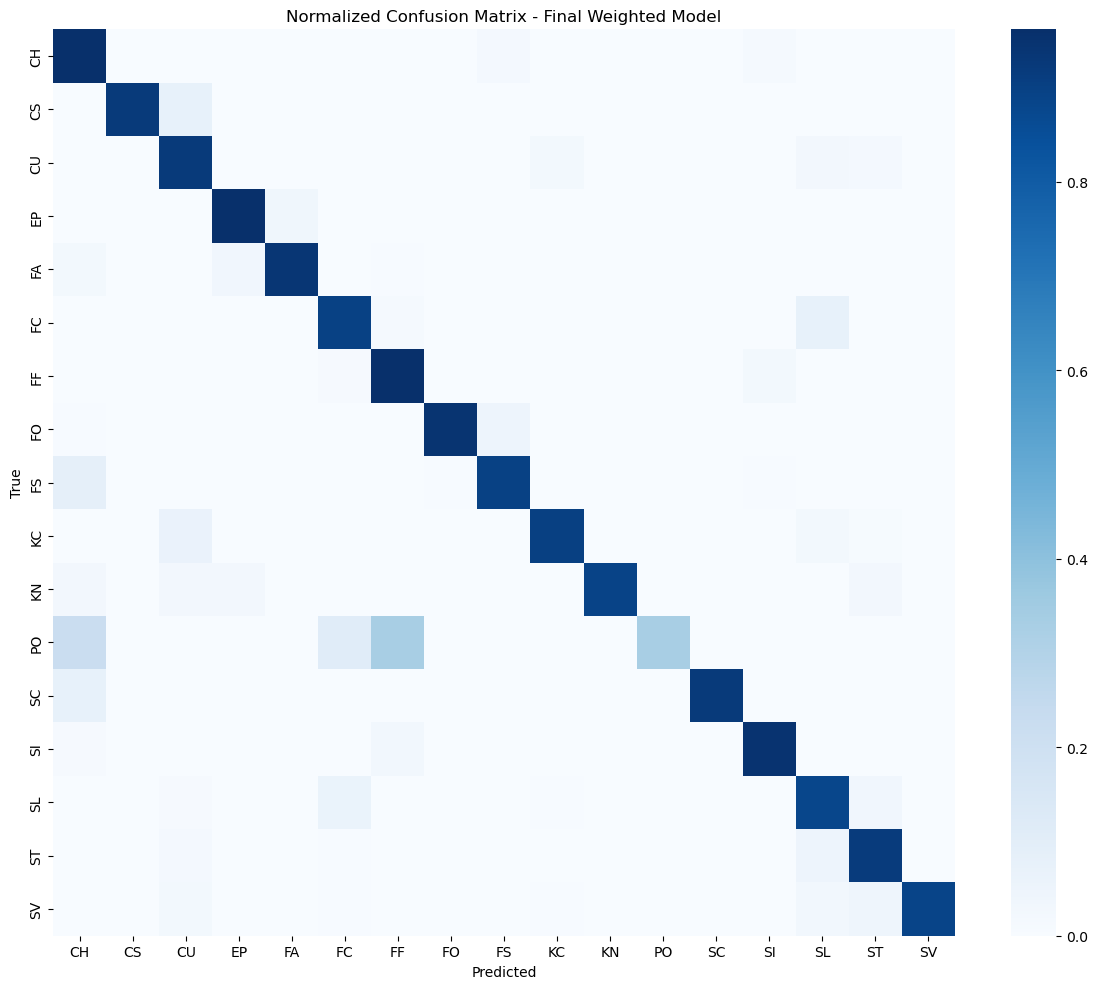

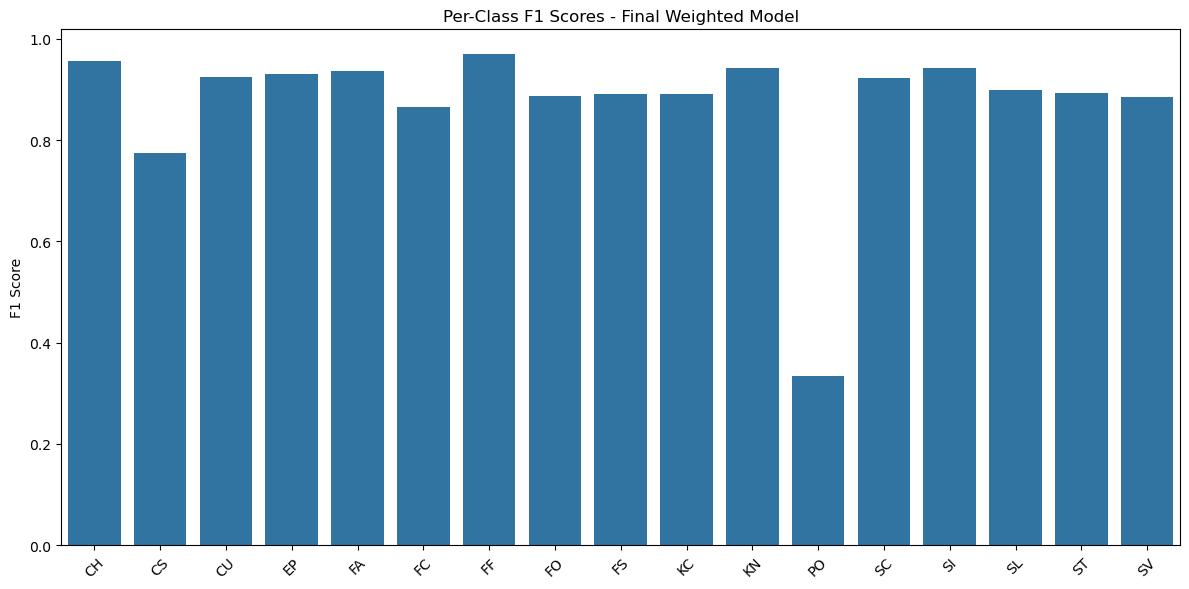

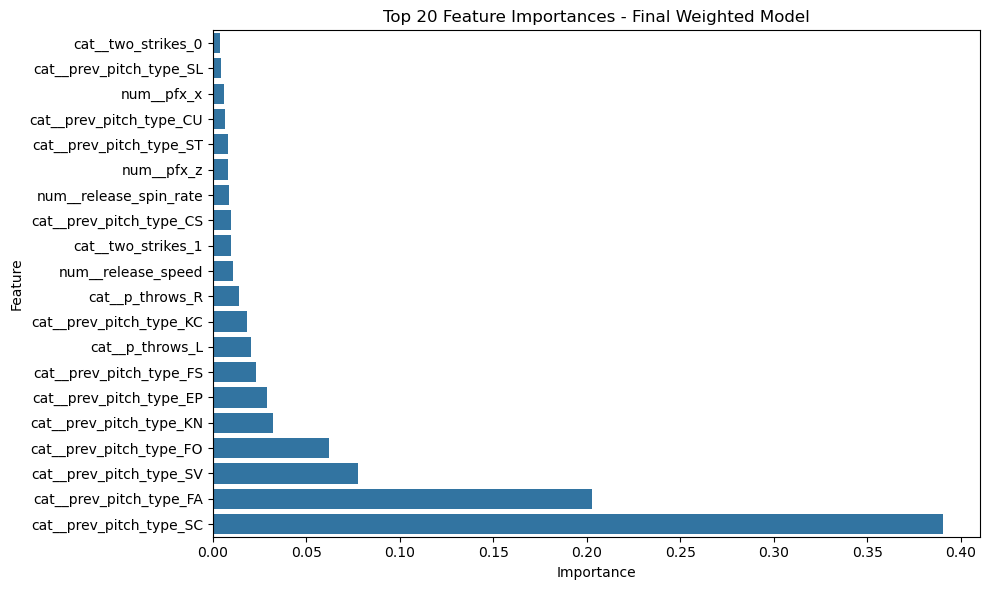

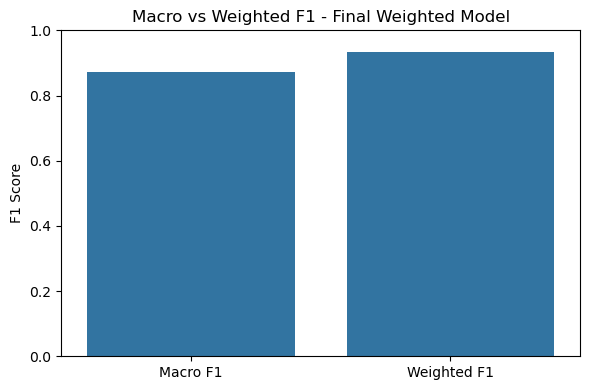

In [13]:
# Plots for Final Weighted Model

# Fit final weighted model
classes = np.unique(y_train_enc)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_enc)
class_weights = dict(zip(classes, weights))

final_model = XGBClassifier(
    n_estimators=844, learning_rate=0.1, max_depth=8,
    subsample=0.9, colsample_bytree=0.7,
    min_child_weight=1, gamma=0,
    reg_lambda=10, reg_alpha=1,
    objective="multi:softmax", eval_metric="mlogloss",
    random_state=42
)
final_model.fit(X_train_proc, y_train_enc,
                sample_weight=[class_weights[label] for label in y_train_enc])

y_pred = final_model.predict(X_test_proc)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# --- 1. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_labels, labels=label_encoder.classes_)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,10))
sns.heatmap(cm_norm, annot=False, cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Normalized Confusion Matrix - Final Weighted Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# --- 2. Per-Class F1 Scores ---
report = classification_report(y_test, y_pred_labels, output_dict=True)
f1_scores = [report[label]['f1-score'] for label in label_encoder.classes_]

plt.figure(figsize=(12,6))
sns.barplot(x=label_encoder.classes_, y=f1_scores)
plt.xticks(rotation=45)
plt.title("Per-Class F1 Scores - Final Weighted Model")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

# --- 3. Feature Importance ---
importances = final_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()
indices = np.argsort(importances)[-20:]  # top 20

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Top 20 Feature Importances - Final Weighted Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- 4. Macro vs Weighted F1 ---
macro_f1 = f1_score(y_test, y_pred_labels, average="macro")
weighted_f1 = f1_score(y_test, y_pred_labels, average="weighted")

plt.figure(figsize=(6,4))
sns.barplot(x=["Macro F1","Weighted F1"], y=[macro_f1, weighted_f1])
plt.title("Macro vs Weighted F1 - Final Weighted Model")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.tight_layout()
plt.show()